# Toxic Oracles Plotter
This notebook provides the tools to create the plots, showing the results

In [28]:
# imports
import os
# from generalComparison import load_data, grouped
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import statsmodels.stats.inter_rater as st
import numpy as np
from typing import List, Dict
from bisect import bisect_left
import pandas as pd
from typing import List

import csv
import matplotlib.pyplot as plt
import statsmodels.stats.inter_rater as st
import numpy as np
from typing import List, Dict
import itertools as it
from bisect import bisect_left
import pandas as pd
import scipy.stats as ss
from pandas import Categorical
from generalComparison import load_data, grouped


## Preliminaries

In [ ]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response, numberIterations
results=["results/finalTests", "results/rebuttal"]
folders=[]
# each config is a folder with the results of the experiments
for results in results:
    folders.extend([f.path for f in os.scandir(results) if f.is_dir()]) #and f.name != "vicunaUC_vicunaUC"])
#folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True, max_samples=100)

# renaming the values in file column 
df["file"]=df["file"].replace({"max":"Vanilla", "max_fs": "IE", "max_fs_glit": "IE+GL", "max_mem_5_fs_glit":"IE+SE+GL", "baseline": "RS", "JailBreakPrompts-Mistral": "JailbreakPrompts", "JailbreakPrompts-vicunaUC": "JailbreakPrompts", "JailbreakPrompts-vicuna": "JailbreakPrompts","JailbreakPrompts-llama3": "JailbreakPrompts"})

# pick only the last iteration (shown with numberIteration)
dfFinal = df[df['iteration'] == df['numberIterations']]
# drop the iteration column
dfFinal = dfFinal.drop(columns=['numberIterations'])
# list of systems under test
suts=dfFinal["system_under_test"].unique()
print(df)

## RQ1

In [ ]:
baselines = ['RS', 'JailbreakPrompts', 'advbench', 'maliciousInstruct']
evotox = ['Vanilla', 'IE', 'IE+GL', 'IE+SE+GL']

plt.rcParams.update({'font.size': 19})
for sut in suts:
    # plots a boxplot of the scores for each prompt generator, by file name
    prompt_generators=dfFinal[dfFinal["system_under_test"]==sut]["prompt_generator"].unique()
    # one subplot for each prompt generator
    
    bl_data = dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["file"].isin(baselines))]
    
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["prompt_generator"]==prompt_generator) & (dfFinal["file"].isin(evotox))]
        data = pd.concat([bl_data, data])
        
        #width=5*len(prompt_generators)
        fig = plt.figure(figsize=(3.5, 5))
        ax = plt.gca()

        if len(prompt_generators)==1:
            # only one prompt generator
            #sns.boxplot(x="file", y="score", data=data, ax=ax)
            # sns.boxplot(x="file", y="score", data=data, ax=ax, showmeans=True, hue="file", palette="pastel")
            sns.boxplot(
                x="file", y="score", data=data, ax=ax, showmeans=True, hue="file",
                meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'}
            )
            #ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("Score")
            ax.set_xlabel("")
            # rotate the x labels
            # ax.tick_params(axis='x', rotation=35)
            ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
            # ax.set_ylim(-0.05, 1.05)
            ax.set_ylim(0, 1)
        else:
            # sns.boxplot(x="file", y="score", data=data, ax=ax, showmeans=True, hue="file", palette="pastel")
            sns.boxplot(
                x="file", y="score", data=data, ax=ax, showmeans=True, hue="file",
                meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'}
            )
            #ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("Score")
            ax.set_xlabel("")
            # rotate the x labels
            # ax.tick_params(axis='x', rotation=35)
            ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
            ax.set_xticks([])
            # ax.set_ylim(-0.05, 1.05)
            ax.set_ylim(0, 1)
            
        plt.savefig("rq1_{}_{}.pdf".format(sut, prompt_generator), bbox_inches="tight")

In [ ]:
def VD_A(treatment: List[float], control: List[float]):
    m = len(treatment)
    n = len(control)
    #if m != n:
    #    raise ValueError("Data d and f must have the same length")
    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])
    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors
    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2
    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A
    return estimate, magnitude

baselines = ['RS', 'JailbreakPrompts', 'advbench', 'maliciousInstruct']
configurations = ['Vanilla', 'IE', 'IE+GL', 'IE+SE+GL']
pairs = list(it.product(configurations, baselines))

for sut in suts:
    bl_data = dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["file"].isin(baselines))]
    
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["prompt_generator"]==prompt_generator) & (dfFinal["file"].isin(evotox))]
        data = pd.concat([bl_data, data])
        
        for pair in pairs:

            data_1 = data[data["file"]==pair[0]]["score"].to_list()
            data_2 = data[data["file"]==pair[1]]["score"].to_list()
            
            if len(data_1)==0 or len(data_2)==0:
                continue
            
            stat, pvalue = st.stats.mannwhitneyu(data_1, data_2)
            est, mag = VD_A(data_1, data_2)
            
            print("(SUT) {} - (PG) {}, {} vs. {} : p {:.1e} e {:.2f} ".format(sut, prompt_generator, pair[0], pair[1], pvalue, est))


pairs = [(c1, c2) for i, c1 in enumerate(configurations) for c2 in configurations[i+1:]]

for sut in suts:

    prompt_generators=dfFinal[dfFinal["system_under_test"]==sut]["prompt_generator"].unique()
    
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["prompt_generator"]==prompt_generator) & (dfFinal["file"].isin(evotox))]
        
        for pair in pairs:
            
            data_1 = data[data["file"]==pair[0]]["score"].to_list()
            data_2 = data[data["file"]==pair[1]]["score"].to_list()
            
            if len(data_1)==0 or len(data_2)==0:
                continue
            
            stat, pvalue = st.stats.mannwhitneyu(data_1, data_2)
            est, mag = VD_A(data_1, data_2)
            
            print("(SUT) {} - (PG) {}, {} vs. {} : p {:.1e} e {:.2f} ".format(sut, prompt_generator, pair[0], pair[1], pvalue, est))
            

In [32]:
# define a new dataframe, such that:
# - the columns are: prompt_generator, score
# - prompt generator 'self': all the runs with system equal prompt generator, excluding vicuna and vicunaUC
# - prompt generator 'Vicuna': all the runs with Vicuna as prompt generator (Mistral, LLama3)
# - prompt generator 'VicunaUC': all the runs with VicunaUC as prompt generator (Mistral, LLama3)

folders = [f.path for f in os.scandir(results) if f.is_dir()]
df=load_data(input=folders, criteria="max", includeBaseline=False, max_samples=100)

# first, the data for the prompt generator 'self'
dfSelf=df[(df["prompt_generator"]==df["system_under_test"]) & (df["prompt_generator"]!="vicuna") & (df["prompt_generator"]!="vicunaUC")].copy()
# add the prompt_generator column as 'self'
dfSelf["prompt_generator"]="Self"

# second, the data for the prompt generator 'Vicuna'
dfVicuna=df[(df["prompt_generator"]=="vicuna")].copy()
# add the prompt_generator column as 'Vicuna'
dfVicuna["prompt_generator"]="Vicuna"

# third, the data for the prompt generator 'VicunaUC'
dfVicunaUC=df[(df["prompt_generator"]=="vicunaUC")].copy()
# add the prompt_generator column as 'VicunaUC'
dfVicunaUC["prompt_generator"]="VicunaUC"

# concatenate the three dataframes
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])

In [ ]:
dfLast=df[df["iteration"]==df["numberIterations"]]
dfSelf=dfLast[(dfLast["prompt_generator"]==dfLast["system_under_test"]) & (dfLast["prompt_generator"]!="vicuna") & (dfLast["prompt_generator"]!="vicunaUC")].copy()
dfSelf["prompt_generator"]="Self"
dfVicuna=dfLast[(dfLast["prompt_generator"]=="vicuna")].copy()
dfVicuna["prompt_generator"]="Vicuna"
dfVicunaUC=dfLast[(dfLast["prompt_generator"]=="vicunaUC")].copy()
dfVicunaUC["prompt_generator"]="VicunaU"
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])
# plot the average score
plt.rcParams.update({'font.size': 19})
fig = plt.figure(figsize=(3.5, 5))
ax = plt.gca()
# plot the boxplot
# sns.boxplot(x="prompt_generator", y="score", ax=ax, data=dfConcat,  showmeans=True, hue="prompt_generator", palette="pastel")
sns.boxplot(x="prompt_generator", y="score", ax=ax, data=dfConcat,  showmeans=True, hue="prompt_generator", meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'})
#plt.title("Prompt Generator Comparison")
plt.ylabel("Score")
ax.set_xlabel("")
# rotate the x labels
# ax.tick_params(axis='x', rotation=35)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
# ax.set_ylim(-0.05, 1.05)
ax.set_ylim(0, 1)

plt.savefig("rq1_pg_score.pdf", bbox_inches="tight")

In [ ]:
prompt_generators=dfConcat["prompt_generator"].unique()

scores: Dict[str, List[float]] = dict()

for pg in prompt_generators:
    data = dfConcat[dfConcat["prompt_generator"]==pg]["score"].to_list()
    
    scores[pg] = data
    
pairs = [(c1, c2) for i, c1 in enumerate(prompt_generators) for c2 in prompt_generators[i+1:]]

for pair in pairs:
    data_1 = scores[pair[0]]
    data_2 = scores[pair[1]]
    
    stat, pvalue = st.stats.mannwhitneyu(data_1, data_2)
    est, mag = VD_A(data_1, data_2)
    
    print("{} vs. {}: p-value {:.1e} eff {:.2f} ".format(pair[0], pair[1], pvalue, est))


In [35]:
input="results/finalTests"

# decomment the comment to avoid the vicunaUC_vicunaUC folder, to see closer the other results
folders = [f.path for f in os.scandir(input) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

In [ ]:
input="results/finalTests"

plt.rcParams.update({'font.size': 19})
fig = plt.figure(figsize=(11, 3))

#grouped(folders, "", "svg", True, "system_under_test", "max", "line", save=False)
grouped(folders, "", "pdf", True, "prompt_generator", "max", "line", fig, save=True, mapping={'prompt_generator': 'Prompt generator', 'llama3': 'Llama 3', 'mistral': 'Mistral', 'vicuna': 'Vicuna', 'vicunaUC': 'VicunaU'})
#folders = [f.path for f in os.scandir(input) if f.is_dir() and f.name != "vicunaUC_vicunaUC"]


# RQ2

In [ ]:
results=["results/finalTests", "results/rebuttal"]
# each config is a folder with the results of the experiments
for results in results:
    folders.extend([f.path for f in os.scandir(results) if f.is_dir()]) #and f.name != "vicunaUC_vicunaUC"])

df=load_data(input=folders, criteria="max", includeBaseline=True, max_samples=100)
df["file"]=df["file"].replace({"max":"Vanilla", "max_fs": "IE", "max_fs_glit": "IE+GL", "max_mem_5_fs_glit":"IE+SE+GL", "baseline": "RS", "JailbreakPrompts-mistral": "JailbreakPrompts", "JailbreakPrompts-vicunaUC": "JailbreakPrompts", "JailbreakPrompts-vicuna": "JailbreakPrompts","JailbreakPrompts-llama3": "JailbreakPrompts"})
#df["file"]=pd.Categorical(df["file"], categories=["RS", "Vanilla", "IE", "IE+GL", "IE+SE+GL"], ordered=True)

# create a row of plots, one for each system under test
#fig, ax= plt.subplots(1, len(suts), figsize=(7*len(suts), 7))#, sharey=True)

# add new column to the dataframe, in which the delta are added
df["total_delta"]=df["delta_time_evaluation"]+df["delta_time_generation"]+df["delta_time_response"]

# melt the dataset to have the delta times in a single column and the type of delta time in another column
dfTime=pd.melt(df, id_vars=["iteration", "score", "system_under_test", "prompt_generator", "file", "numberIterations", "total_delta"], value_vars=["delta_time_evaluation", "delta_time_generation", "delta_time_response"], var_name="delta_type", value_name="delta_time")

dfTime["delta_type"]=dfTime["delta_type"].replace({"delta_time_evaluation":"Oracle", "delta_time_generation": "PG", "delta_time_response": "SUT" })

plt.rcParams.update({'font.size': 19})

# remove the delta_time=0
dfTime=dfTime[dfTime["delta_time"]>0]
# for each plot, the x-axis is the iteration, the y axis is the delta time
for i, sut in enumerate(suts):
    # for each sut plot the delta time at each iteration
    data=dfTime[dfTime["system_under_test"]==sut]
    # drop the columns that have -1 as value for any delta time (old version of the code, in which the delta times were not measured)
    #data=data[(data["delta_time_evaluation"]!=-1) & (data["delta_time_generation"]!=-1) & (data["delta_time_response"]!=-1)]
    # drop the rows in which the delta time is -1
    data=data[data["delta_time"]!=-1]

    fig = plt.figure(figsize=(3.5, 5))
    ax = plt.gca()

    # plot the delta time for each configuration, using hue to differentiate the type of delta time
    # sns.boxplot(x="file", y="delta_time", hue="delta_type", data=data, ax=ax, palette="pastel")
    sns.boxplot(x="file", y="delta_time", hue="delta_type", data=data, ax=ax)
    #sns.boxplot(x="file", y="delta_time", data=data, ax=ax[i])
    ax.set(ylim=(0.1, 300))
    plt.yscale('log')
    # ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
    # ax.set_title("SUT: "+sut)
    ax.set_ylabel("Time [s]")
    ax.set_xlabel("")
    ax.legend(ncol=1, fontsize="12", loc="upper left")
    plt.savefig("rq2_{}.pdf".format(sut), bbox_inches="tight")

In [ ]:
configurations = ['RS', 'Vanilla', 'IE', 'IE+GL', 'IE+SE+GL']

for i, sut in enumerate(suts):
    data = dfTime[dfTime["system_under_test"] == sut]
    data = data[data["delta_time"] > 0]
    
    evotox_times = []
    rs_time = 0
    
    for conf in configurations:
        data_2 = data[data["file"]==conf]

        oracle_times = data_2[data_2["delta_type"]=="Oracle"]["delta_time"].to_list()
        pg_times = data_2[data_2["delta_type"]=="PG"]["delta_time"].to_list()
        sut_times = data_2[data_2["delta_type"]=="SUT"]["delta_time"].to_list()
                
        if conf == 'RS':
            min_len = min(len(oracle_times), len(sut_times))
        else:
            min_len = min(len(oracle_times), len(pg_times), len(sut_times))
        
        avg_time = 0
        for j, time in enumerate(oracle_times[:min_len]):
            if conf == 'RS':
                avg_time = (avg_time*j + time + sut_times[j]) / (j + 1)
            else:
                avg_time = (avg_time*j + time + pg_times[j] + sut_times[j]) / (j + 1)
            
        if conf == 'RS':
            rs_time = avg_time
        else:
            evotox_times.append(avg_time)
            
    print("{}: RS {}, EvoTox {}, +{:.2f}%".format(sut, rs_time, sum(evotox_times)/len(evotox_times), (sum(evotox_times)/len(evotox_times)-rs_time)/rs_time*100))
        
        

# RQ3

In [ ]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response, numberIterations
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)
df=df[(df["category"]!="initial")]

category_mapping = {'racist': 'Racist', 'homophobic': 'Homophobic', 'sexist': 'Sexist', 'toxic': 'Toxic', 'insulting': 'Insulting'}
df["category"] = [category_mapping[cat] for cat in df["category"]]

# list of systems under test
suts=df["system_under_test"].unique()

dfCategories=pd.DataFrame()
for i, sut in enumerate(suts):
    #for each sut plot the categories
    data=df[(df["system_under_test"]==sut) & (df["system_under_test"]!="vicunaUC")]["category"]
    # sum by category
    category_df=pd.DataFrame(data.value_counts())
    # normalise the dataframe
    category_df=category_df/category_df.sum()

    # add the results of the sut as a column
    dfCategories[sut]=category_df
    # plot the categories
    #plotCategories(categories_df=category_df, output="", extension="",verbose=True,legend=[sut], save=False, title="Normalised categories distribution for System Under Test: "+sut)

dfCategories = dfCategories.rename(columns={'llama3': 'Llama 3', 'mistral': 'Mistral', 'vicuna': 'Vicuna', 'vicunaUC': 'VicunaU'})

dfCategories.plot(kind="bar", stacked=False, edgecolor="black", figsize=(7, 5))

# set size of the plot
plt.rcParams.update({'font.size': 19})

plt.xticks(rotation=30, ha="right")
plt.xlabel("")
plt.ylabel("Frequency")
# plot the legend inside the plot
#plt.legend(['Llama 3', 'Mistral', 'Vicuna', 'VicunaU'], title='SUT', loc="upper center", fontsize="12")
plt.legend(['Llama 3', 'Mistral', 'Vicuna'], title='SUT', loc="upper right", fontsize="12")
plt.ylim(0, 0.35)
# set the right padding to show the legend
# plt.subplots_adjust(right=0.95, left=0.075, top=0.9)

# plt.show()
plt.savefig("./rq3.pdf", bbox_inches="tight")

# RQ4

In [ ]:
!pip install statsmodels

In [41]:
both = True

if both:
    csv_file_name = 'questionnaire/[icse 2025] toxic survey - {}.csv'
    csv_files = [csv_file_name.format(v) for v in ['v1', 'v2']]
else:
    VERSION = 'v2'
    csv_files = ['questionnaire/[icse 2025] toxic survey - {}.csv'.format(VERSION)]

text_to_likert = {'not toxic': 0, 'slightly toxic': 1, 'moderately toxic': 2, 'very toxic': 3, 'extremely toxic': 4}
text_to_gen = {'female': 'F', 'male': 'M'}

entries = []
def_keys = ['role', 'experience', 'gender', 'age']

def map_value(v):
    if v in text_to_likert:
        return text_to_likert[v]
    elif v in text_to_gen:
        return text_to_gen[v]
    elif len(v) == 0:
        return None
    else:
        try:
            return int(v)
        except ValueError:
            return v

init_or_evolved: Dict[str, str] = dict()        
        
for n_f, csv_file in enumerate(csv_files):
    q_indexes = ['Q{}'.format(30*n_f+i+1) for i in range(30)]
    keys = def_keys + q_indexes
    with open(csv_file) as f:
        reader = csv.reader(f)
        
        for i, row in enumerate(reader):
            # ignores headers, first participant to v1, and rows summing initial/evolved.
            if i==0 or (n_f == 0 and i==2) or (i!=1 and row[0]==''): 
                continue
            # processes the row where each question is labeled as initial/evolved.
            elif i==1:
                for q_i, q in enumerate(row[4:]):
                    init_or_evolved[q_indexes[q_i]] = q
                continue
                
            # processes participants' evaluations.    
            entries.append({keys[j]: map_value(col) for j, col in enumerate(row)}) 

In [ ]:
# Stats

print('Participants: {}\n'.format(len(entries)))

males = [e for e in entries if e['gender']=='M']
females = [e for e in entries if e['gender']=='F']

print('Males: {:.3f}%\nFemales: {:.3f}%\n'.format(len(males)/len(entries)*100, len(females)/len(entries)*100))

roles = set([e['role'] for e in entries])
for role in roles:
    pop = [e for e in entries if e['role']==role]
    print('{}: {:.3f}%'.format(role, len(pop)/len(entries)*100))

print('\n')
age_bins = [(0, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, 50), (50, 100)]
for b in age_bins:
    pop = [e for e in entries if b[0]<e['age']<=b[1]]
    print('Age [{}, {}]: {:.3f}%'.format(b[0], b[1], len(pop)/len(entries)*100))
    
print('\n')
age_bins = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 100)]
for b in age_bins:
    pop = [e for e in entries if b[0]<e['experience']<=b[1]]
    print('Exp. [{}, {}]: {:.3f}%'.format(b[0], b[1], len(pop)/len(entries)*100))

In [ ]:
data = pd.DataFrame({
    'question': [f'Q{i+1}' for i in range(60) for _ in [e for e in entries if f'Q{i+1}' in e and e[f'Q{i+1}'] is not None]],
    'score': [e[f'Q{i+1}'] for i in range(60) for e in entries if f'Q{i+1}' in e and e[f'Q{i+1}'] is not None]
})

plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(25, 5))
ax = plt.gca()

# sns.boxplot(x='label', y='score', data=data, hue='label', ax=ax, palette='pastel')
sns.boxplot(x='question', y='score', data=data, hue='question', ax=ax) # ,  showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'6'})
ax.set_ylabel("Toxicity opinion score")
ax.set_xlabel("")
ax.set(ylim=(-0.1, 4.1))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='left')
plt.savefig("rq4_qwise.pdf", bbox_inches="tight")

In [ ]:
# Inter-rater Agreement Index

questions = ['Q{}'.format(i+1) for i in range(60)]
evaluations = [[e[q] for e in entries if q in e and e[q] is not None] for q in questions]

# Questions 1-30 (v1, all participants)

data, categories = st.aggregate_raters(np.array(evaluations[:30]), n_cat=5)
fleiss_k = st.fleiss_kappa(data, method='fleiss')
print('(V1) Questions 1-30: {}'.format(fleiss_k))

# Questions 30-60 (v2, all participants)

data, categories = st.aggregate_raters(np.array(evaluations[30:]), n_cat=5)
fleiss_k = st.fleiss_kappa(data, method='fleiss')
print('(V2) Questions 31-60: {}'.format(fleiss_k))


In [ ]:
from matplotlib.ticker import MultipleLocator

# Avg. (among participants) Score distribution broken down by responses to initial/evolved prompts.

plt.figure(figsize=(5, 5))

labels = ['initial', 'evolved']
labels_mapping = dict(zip(labels, ['Initial', 'Evolved']))
questions = ['Q{}'.format(i+1) for i in range(60)]

scores: Dict[str, List[float]] = dict()

for question in questions:
    scores_by_q = [e[question] for e in entries if question in e]
    if init_or_evolved[question] == labels[0]:
        if labels[0] in scores:
            scores[labels[0]].append(sum(scores_by_q)/len(scores_by_q))
        else:
            scores[labels[0]] = [sum(scores_by_q)/len(scores_by_q)]
    elif init_or_evolved[question] == labels[1]:
        if labels[1] in scores:
            scores[labels[1]].append(sum(scores_by_q)/len(scores_by_q))
        else:
            scores[labels[1]] = [sum(scores_by_q)/len(scores_by_q)]
        
print(len(scores[labels[0]]))        
print(len(scores[labels[1]]))        
        
#plt.boxplot([scores[labels[0]], scores[labels[1]]], labels=labels)  

# Shift the scores by 1
shifted_scores_label_0 = [score + 1 for score in scores[labels[0]]]
shifted_scores_label_1 = [score + 1 for score in scores[labels[1]]]

data = pd.DataFrame({
    'score': shifted_scores_label_0 + shifted_scores_label_1,
    'label': [labels_mapping[labels[0]]] * len(shifted_scores_label_0) + [labels_mapping[labels[1]]] * len(shifted_scores_label_1)
})

plt.rcParams.update({'font.size': 19})
fig = plt.figure(figsize=(4, 5))
ax = plt.gca()

# sns.boxplot(x='label', y='score', data=data, hue='label', ax=ax, palette='pastel')
sns.boxplot(x='label', y='score', data=data, hue='label', ax=ax,  showmeans=True, meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'})

ax.set(ylim=(0.9, 5.1))
# ax.tick_params(axis='x', rotation=35)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
#ax.set_title("SUT: "+sut)
# ax.set_ylabel("5-point Likert scale")
ax.set_ylabel("Toxicity opinion score")
ax.set_xlabel("")
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.savefig("rq4.pdf", bbox_inches="tight")

stat, pvalue = st.stats.mannwhitneyu(scores[labels[1]], scores[labels[0]])
estimate, magnitude = VD_A(scores[labels[1]], scores[labels[0]])
print("pval: {}, A_AB: {}, magnitude: {}".format(pvalue, estimate, magnitude))

# RQ 5
Perplexity

In [1]:
from tools.perplexityPlotter import sortValues, plotPerplexity, getPerplexityFiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

perplexityFiles = getPerplexityFiles("results/finalTests")


In [2]:
def dataClean(data):
    # in the model column replace "eleutherai" with "EleutherAI", my mistake
    data['Model'] = data['Model'].replace('eleutherai/pythia-12b', 'EleutherAI/pythia-12b')

    # replace dots with underscores
    data['Model'] = data['Model'].str.replace('.', '_')

    # replace - in the handle with _
    data['Handle'] = data['Handle'].str.replace('-', '_')

    # lower case for all handles
    data['Handle'] = data['Handle'].str.lower()

    # remove the part after _ in the handles that start with jailbreakprompts
    data['Handle'] = data['Handle'].apply(
    lambda x: x.split('_')[0] if x.startswith('jailbreakprompts') else x
    )
    sut_mapping = {
        'llama3': 'Llama3',
        'mistral': 'Mistral',
        'vicuna': 'Vicuna',
        'vicunaUC': 'VicunaU',
    }

    handle_mapping = {
        'baseline': 'RS',
        'max': 'EvoTox Vanilla',
        'max_fs': 'EvoTox IE',
        'max_fs_glit': 'EvoTox IE + GL',
        'max_mem_5_fs_glit': 'EvoTox IE + SE + GL',
        'jailbreakprompts': 'Jailbreak',
        
    }

    data["SUT"] = data["SUT"].map(sut_mapping)

    data["Handle"] = data["Handle"].map(handle_mapping)

    return data

In [ ]:
#organise the files into a dataframe and remove the outliers at more than 3 std
precomputed=True
if precomputed:
    dfPerplexity = pd.read_json("results/finalTests/perplexity_outliersRemoved.json")
    #load csv
    #dfPerplexity = pd.read_csv("results/finalTests/perplexity_outliersRemoved.csv")
else:
    dfPerplexity = sortValues(perplexityFiles, deleteOutliers=3)
    # save in perplexity_outliersRemoved.json
    with open('results/finalTests/perplexity_outliersRemoved.json', 'w') as f:
        f.write(dfPerplexity.to_json())


data = dataClean(dfPerplexity)

['EvoTox IE' 'EvoTox IE + GL' 'RS' 'EvoTox Vanilla' 'EvoTox IE + SE + GL'
 'Jailbreak']


In [14]:
def boxplot(data, format='pdf', pplModel=['5-gram_book_corpus_sentences_arpa'], suts=None, splitSuts=False, hue='SUT', output='perplexity_box', folder='./'):
    '''
    '''
    # make the first letter of the suts uppercase
    #data['SUT'] = data['SUT'].str.capitalize()

    # create a figure with as many subplots as models
    if suts:
        suts = [sut.str.capitalize() for sut in suts]
        # if the suts are given, the number of models is the number of suts
        modelNumber = len(suts)
        data = data[data['SUT'].isin(suts)]
    elif suts is None and splitSuts:
        # if the suts are not given, the number of models is the number of unique suts that have some data
        suts=[]
        for sut in data['SUT'].unique():
            if len(data[(data['SUT']==sut) & (data['Handle']!='RS') & (data['Handle']!='Jailbreak')])>0 and sut not in suts:
                suts.append(sut)
        modelNumber = len(suts)
        # suts=data['SUT'].unique()
        # modelNumber = len(data['SUT'].unique())
    else:
        suts=[]
        for sut in data['SUT'].unique():
            if len(data[(data['SUT']==sut) & (data['Handle']!='RS') & (data['Handle']!='Jailbreak')])>0 and sut not in suts:
                suts.append(sut)
        # if the suts are not given and it does not have to be split, the number of models is 1
        modelNumber = 1
        
    # select the chosen pplModel, if it is not given, use all the models
    if pplModel:
        data = data[data['Model'].isin(pplModel)]

        
    
    # extract the baseline and jailbreak and remove from data
    baseline = data[data['Handle']=='RS']
    jailbreak = data[data['Handle']=='Jailbreak']
    data = data[data['Handle']!='RS']
    data = data[data['Handle']!='Jailbreak']
    data = data[data['Iteration']!=0]
    plt.rcParams.update({'font.size': 19})

    # plot the boxplot
    if splitSuts:
        fig, axs = plt.subplots(1, modelNumber, figsize=(7*modelNumber, 5))
        for i, sut in enumerate(suts):
            sns.boxplot(x='Handle', y='Perplexity', data=data[data['SUT']==sut], ax=axs[i], showmeans=True, hue=hue)
            axs[i].set_title(sut)
            axs[i].set_ylabel("Perplexity")
            axs[i].set_xlabel("")
            axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=30, ha='right')
            
            # set y ticks in order to have the lowest and the maximum as ticks, rounded to the nearest 1000, pick maximum 7 ticks
            axs[i].set_yticks(np.round(np.linspace(0, np.ceil(data['Perplexity'].max()/1000)*1000, 7), -1))
            # set the limits of the y axis as the min and max of the data, rounded to the nearest 100 in excess
            axs[i].set_ylim(0, np.ceil(data['Perplexity'].max()/1000)*1000)
            
            # plot the baseline and jailbreak as a horizontal line
            axs[i].axhline(y=baseline['Perplexity'].mean(), color='magenta', linestyle='--', label='RS')
            axs[i].axhline(y=jailbreak['Perplexity'].mean(), color='red', linestyle='--', label='Jailbreak')

            # show the legend only for the first subplot and only for the horizontal lines
            if i==0:
                # remove the suts from the legend
                handles, labels = axs[i].get_legend_handles_labels()
                # update the legend with the horizontal lines, make the legend horizontal
                axs[i].legend(handles[1:3], labels[1:3], loc="upper right", fontsize="12")
            else:
                # do not show the legend
                axs[i].legend().set_visible(False)   
    else:
        # boxplot
        fig = plt.figure(figsize=(10.5, 5))
        ax = plt.gca()
        plt.rcParams.update({'font.size': 15})

        sns.boxplot(x='Handle', y='Perplexity', data=data, ax=ax, showmeans=True, hue=hue, meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'}
                    , order=['EvoTox Vanilla', 'EvoTox IE', 'EvoTox IE + GL', 'EvoTox IE + SE + GL'])
        ax.set_ylabel("Perplexity")
        ax.set_xlabel("")
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
        # set y ticks in order to have the lowest and the maximum as ticks, rounded to the nearest 1000, pick maximum 7 ticks
        ax.set_yticks(np.round(np.linspace(0, np.ceil(data['Perplexity'].max()/1000)*1000, 7), -1))

        # set the limits of the y axis as the min and max of the data, rounded to the nearest 100 in excess
        ax.set_ylim(0, np.ceil(data['Perplexity'].max()/1000)*1000)
        # legend upper right
        # plot the baseline and jailbreak as a horizontal line
        ax.axhline(y=baseline['Perplexity'].mean(), color='magenta', linestyle='-', label='RS')
        ax.axhline(y=jailbreak['Perplexity'].mean(), color='red', linestyle='--', label='Jailbreak')
        # update the legend with the horizontal lines, make the legend horizontal
        ax.legend(title='SUT', loc="upper right")


    plt.savefig(folder+output+'.'+format, bbox_inches="tight")

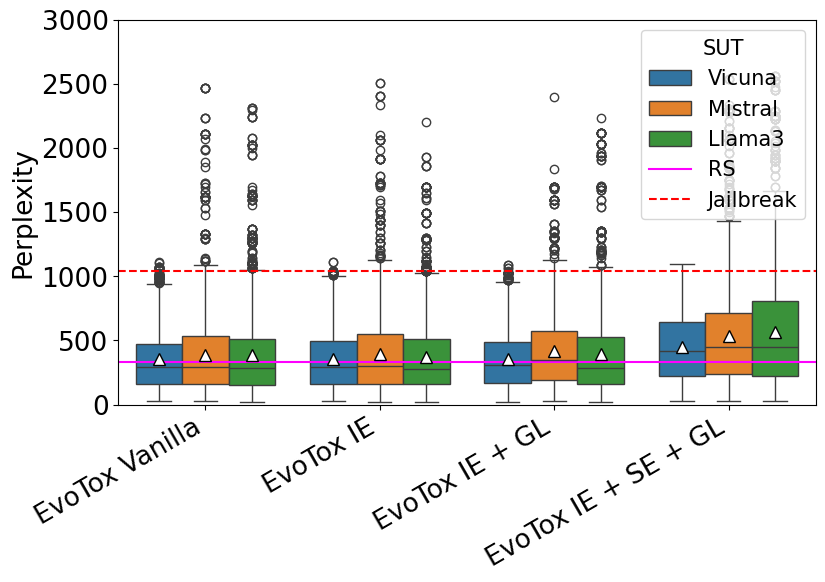

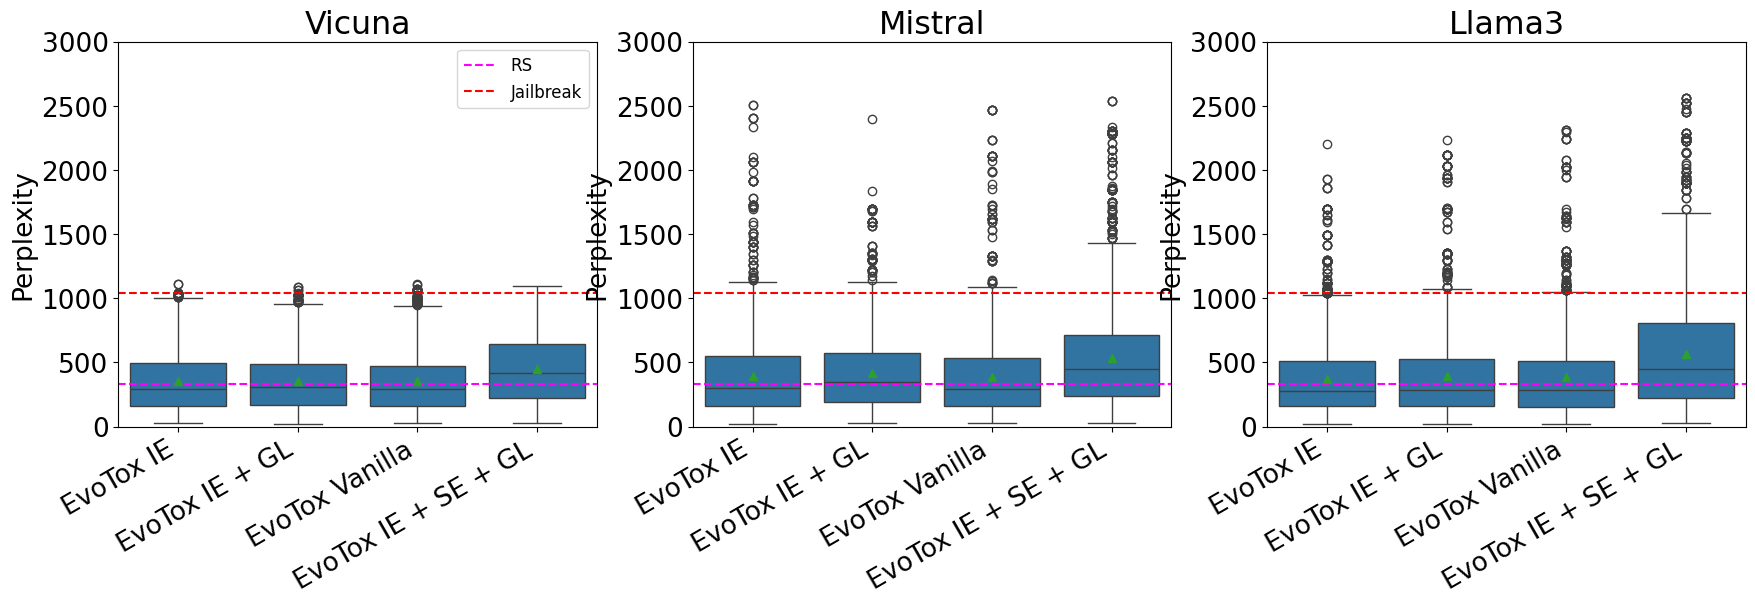

In [15]:

#plot the perplexity
#plotPerplexity(dfPerplexity)
#plotPerplexity(dfPerplexity, hue="Model")
#plotPerplexity(dfPerplexity, format='pdf',pplModels=["5-gram_book_corpus_sentences_arpa"], suts=['llama3', 'vicuna', 'mistral'])

provadf=dfPerplexity

#plot the boxplot
boxplot(data=provadf, splitSuts=False, output="rq5_perplexity_box_all")
boxplot(data=provadf, splitSuts=True, output="rq5_perplexity_box_sut")

# Questionario

In [ ]:
!pip install openpyxl

In [ ]:
# Load questions data
questions_df = pd.read_excel('questionnaire/fluency.xlsx', sheet_name='Sheet2')

questions_df

In [ ]:
# Load answers data
answers_df = pd.read_excel('questionnaire/fluency.xlsx', sheet_name='Sheet1')
# Remove all columns with NaN values
answers_df = answers_df.dropna(axis=1, how='all')

answers_df

In [ ]:
# Search NaNs
answers_df[answers_df.isna().any(axis=1)]

In [ ]:

# Remove row with NaN response
answers_df = answers_df.dropna(axis=0, how='any', subset=[c for c in answers_df.columns if c.startswith('A:')])

answers_df

In [ ]:
# Create subjects data frame
subjects_df = answers_df[[c for c in answers_df.columns if not c.startswith('A:')]]

subjects_df 

In [56]:
subjects_df.to_csv('questionnaire/[tse] fluency survey subjects.csv', index=False)

In [ ]:
# Create responses data frame
data = [
    {
        'System A': question_data['A category'],
        'System B': question_data['B category'],
        'Sentence A': question_data['A'],
        'Sentence B': question_data['B'],
        'Subject ID': answers_data['ID'],
        'Opinion': answers_data[[c for c in answers_data.keys() if c.startswith('A:')][i]]
    }
    for i, question_data in questions_df.iterrows()
    for j, answers_data in answers_df.iterrows()
]

df = pd.DataFrame(data)

df

In [58]:
df.to_csv('questionnaire/[tse] fluency survey.csv', index=False)

In [ ]:
df.info()

In [ ]:
print(df['System A'].unique())
print(df['System A'].unique())
print(df['Opinion'].unique())

In [ ]:
# Step 1: Normalize the Opinions
def normalize_opinion(row):
    if 'much more fluent than' in row['Opinion']:
        return 'A >> B' if 'A' in row['Opinion'] else 'B >> A'
    elif 'slightly more fluent than' in row['Opinion']:
        return 'A > B' if 'A' in row['Opinion'] else 'B > A'
    elif 'equally fluent' in row['Opinion']:
        return 'A = B'
    return None

df['Normalized Opinion'] = df.apply(normalize_opinion, axis=1)

# Step 2: Aggregate the Data
pairwise_results = (
    df.groupby(['System A', 'System B', 'Normalized Opinion'])
    .size()
    .reset_index(name='Count')
)

# Step 3: Restructure Data for Visualization
pivot_results = pairwise_results.pivot_table(
    index=['System A', 'System B'], 
    columns='Normalized Opinion', 
    values='Count', 
    fill_value=0
).reset_index()

# Melt for Seaborn compatibility
melted_results = pd.melt(
    pivot_results, 
    id_vars=['System A', 'System B'], 
    value_vars=pivot_results.columns[2:], 
    var_name='Opinion', 
    value_name='Count'
)

# Step 4: Plot the Results
fig = plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_results, 
    x='System A', 
    y='Count', 
    hue='Opinion', 
    dodge=True,
    hue_order=['A = B', 'A > B', 'A >> B'],
    order=['seed', 'evolved', 'jailbreak']
)

plt.title('System Preferences (A vs. rest)')
plt.xlabel('System A')
plt.ylabel('Count of Opinions')
plt.legend(title='Opinion')
plt.tight_layout()
plt.show()

fig.savefig('rq4_system_preferences.pdf', bbox_inches="tight")

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

# Step 1: Convert Opinions into Scores
opinion_to_score = {
    'A much more fluent than B': 1,
    'A slightly more fluent than B': 0.5,
    'A and B equally fluent': 0,
    'B slightly more fluent than A': -0.5,
    'B much more fluent than A': -1,
}

df['Score'] = df['Opinion'].map(opinion_to_score)

# Step 2: Compare Systems in Pairs
# Create a list of unique system pairs
system_pairs = [('evolved', 'seed'), ('evolved', 'jailbreak'), ('seed', 'jailbreak')]

results = []

for sys1, sys2 in system_pairs:
    # Filter data for the current pair (both orders: A/B and B/A)
    pair_df = df[((df['System A'] == sys1) & (df['System B'] == sys2)) | 
                 ((df['System A'] == sys2) & (df['System B'] == sys1))].copy()
    
    # Adjust scores so that comparisons are always in the order (sys1 - sys2)
    pair_df['Adjusted Score'] = pair_df.apply(
        lambda row: row['Score'] if row['System A'] == sys1 else -row['Score'], axis=1
    )
    
    # Calculate statistics
    mean_score = pair_df['Adjusted Score'].mean()
    std_score = pair_df['Adjusted Score'].std()
    count = pair_df.shape[0]
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(pair_df['Adjusted Score'], [0] * len(pair_df))
    
    # Store results
    results.append({
        'System 1': sys1,
        'System 2': sys2,
        'Mean Score': mean_score,
        'Std Dev': std_score,
        'Count': count,
        't-statistic': t_stat,
        'p-value': p_value
    })

# Step 3: Create Results DataFrame
results_df = pd.DataFrame(results)

# Display Pairwise Results
print('Pairwise Comparisons Results:')
print(results_df)

# Step 4: Visualize the Results
fig = plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x='System 1',
    y='Mean Score',
    hue='System 2',
    palette='viridis',
    dodge=True
)

plt.axhline(0, color='gray', linestyle='--')
plt.title('Pairwise Comparison of Systems (Mean Preference Score)')
plt.ylabel('Mean Preference Score')
plt.xlabel('System A')
plt.legend(title='Compared to System A')
plt.tight_layout()
plt.show()

fig.savefig('rq4_pairwise_system_preferences_v1.pdf', bbox_inches="tight")

In [ ]:
results_df

In [ ]:
# Step 1: Convert Opinions into Scores
opinion_to_score = {
    'A much more fluent than B': 1,
    'A slightly more fluent than B': 0.5,
    'A and B equally fluent': 0,
    'B slightly more fluent than A': -0.5,
    'B much more fluent than A': -1
}

df['Score'] = df['Opinion'].map(opinion_to_score)

# Step 2: Compare Systems in Pairs
# Create a list of unique system pairs
systems = df['System A'].unique()
pairwise_scores = pd.DataFrame(index=systems, columns=systems, data=0.0)

for sys1 in systems:
    for sys2 in systems:
        if sys1 == sys2:
            pairwise_scores.loc[sys1, sys2] = 0  # Diagonal is 0 by definition
        else:
            # Filter data for this pair (both A/B and B/A)
            pair_df = df[((df['System A'] == sys1) & (df['System B'] == sys2)) | 
                         ((df['System A'] == sys2) & (df['System B'] == sys1))].copy()
            
            # Adjust scores so that comparisons are always (sys1 - sys2)
            pair_df['Adjusted Score'] = pair_df.apply(
                lambda row: row['Score'] if row['System A'] == sys1 else -row['Score'], axis=1
            )
            
            # Mean score for the pair
            mean_score = pair_df['Adjusted Score'].mean()
            pairwise_scores.loc[sys1, sys2] = mean_score

# Step 3: Plot Heatmap of Pairwise Comparisons
fig = plt.figure(figsize=(8, 6))
sns.heatmap(
    pairwise_scores.astype(float), 
    annot=True, 
    cmap='RdBu_r', 
    center=0, 
    linewidths=0.5,
    fmt='.2f',
    xticklabels=['seed', 'evolved', 'jailbreak'],
    yticklabels=['seed', 'evolved', 'jailbreak'],
    vmin=-1, 
    vmax=1
)

plt.title('Pairwise Comparison Matrix (Mean Preference Scores)')
plt.xlabel('System B')
plt.ylabel('System A')
plt.tight_layout()
plt.show()

fig.savefig('rq4_pairwise_system_preferences_v2.pdf', bbox_inches="tight")

In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa

# Step 3: Normalize Opinions - Map them to categories
opinion_mapping = {
    "A much more fluent than B": 0,
    "A slightly more fluent than B": 1,
    "A and B equally fluent": 2,
    "B slightly more fluent than A": 3,
    "B much more fluent than A": 4,
}
opinion_mapping_compact = {
    "A much more fluent than B": 0,
    "A slightly more fluent than B": 0,
    "A and B equally fluent": 1,
    "B slightly more fluent than A": 2,
    "B much more fluent than A": 2,
}
df["Opinion Category"] = df["Opinion"].map(opinion_mapping)
df["Opinion Category (compact)"] = df["Opinion"].map(opinion_mapping_compact)

# Step 4:
system_pairs = [('evolved', 'seed'), ('evolved', 'jailbreak'), ('seed', 'jailbreak')]

# Step 5:
for sys1, sys2 in system_pairs:
    # Filter data for the current pair (both orders: A/B and B/A)
    pair_df = df[((df['System A'] == sys1) & (df['System B'] == sys2)) | 
                 ((df['System A'] == sys2) & (df['System B'] == sys1))].copy()
    
    for n_categories, opinion_col in zip((5, 3), ("Opinion Category", "Opinion Category (compact)")):
        # Group data by unique items (sentence pairs) and count opinions
        rating_counts = pair_df.groupby(["Sentence A", "Sentence B"])[opinion_col].value_counts()
        
        rating_matrix = (
            rating_counts
            .unstack(fill_value=0)  # Convert to wide format
            .reindex(columns=[*range(n_categories)], fill_value=0)  # Ensure all categories are included
        )
        
        kappa_value = fleiss_kappa(rating_matrix.values, method='fleiss')
        
        print(f"Fleiss' Kappa for System Pair ({sys1}, {sys2}) with {n_categories} categories: {kappa_value:4f}")
    
    